# NLP Part 1


In [1]:
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import string
import matplotlib.pyplot as plt
from tqdm import notebook


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BaseNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

sns.set_style('whitegrid')

## Get the Data

Creating a spam filter for SMS from the UCI datasets https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [1]:
messages = [line.rstrip() for line in open('./data/06_NLP_SMSSpamCollection.csv')]
print(len(messages))

5574


In [2]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

`tab` separated dataset

In [4]:
df = pd.read_csv('./data/SMSSpamCollection.csv', sep='\t',
                      names=['label', 'message'])

In [5]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [6]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [7]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

# Feature engineering

Add the length of the SMS as a feature

In [9]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Visualisation

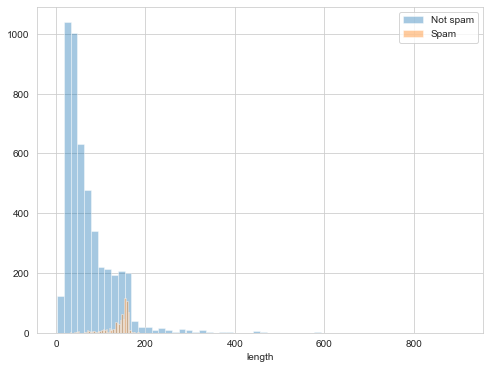

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(df[df['label'] == 'ham']['length'], kde=False, bins=60, label='Not spam')
sns.distplot(df[df['label'] == 'spam']['length'], kde=False, bins=60, label='Spam')
plt.legend()
plt.show()

Longest message

In [11]:
df['label'].iloc[df['length'].idxmax()], df['message'].iloc[df['length'].idxmax()]

('ham',
 "For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..")

## Text Pre-processing

Creating a bag-of-words (bow)

In [12]:
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
def text_process(sms):
    stopwords = nltk.corpus.stopwords.words('english')
    """
    Removes all punctuation
    Removes all stopwords
    Returns a list of the cleaned text
    """
    
    nopunc = [char for char in sms if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords]

In [14]:
df['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

-> Maybe try part-of-speech tagging

In [15]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['message'])
print(len(bow_transformer.vocabulary_))

11425


### Example with one SMS

Example with one SMS message and get the bag-of-words counts as a vector using `bow_transformer`:

In [16]:
example_SMS = df['message'][np.random.randint(0, len(df))]
print(example_SMS)

Erm... Woodland avenue somewhere. Do you get the parish magazine, his telephone number will be in there.


Now let's see its vector representation:

In [17]:
example_bow = bow_transformer.transform([example_SMS])
print(example_bow)
print(example_bow.shape)

  (0, 1789)	1
  (0, 4341)	1
  (0, 4863)	1
  (0, 6824)	1
  (0, 7985)	1
  (0, 8508)	1
  (0, 8733)	1
  (0, 9922)	1
  (0, 10353)	1
(1, 11425)


In [18]:
print(bow_transformer.get_feature_names()[5580])
print(bow_transformer.get_feature_names()[9633])

coins
sell


## Use the `bow` to the entire df

In [19]:
df_bow = bow_transformer.transform(df['message'])

In [20]:
print('Shape of Sparse Matrix: ', df_bow.shape)
print('Amount of Non-Zero occurences: ', df_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


## Using `TfidfTransformer`
(*term frequency-inverse document frequency*)

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

### Applying the `Tfidf` to the `example_bow` from the `example_SMS` from above

In [21]:
example_SMS

'Erm... Woodland avenue somewhere. Do you get the parish magazine, his telephone number will be in there.'

In [22]:
print(example_bow)

  (0, 1789)	1
  (0, 4341)	1
  (0, 4863)	1
  (0, 6824)	1
  (0, 7985)	1
  (0, 8508)	1
  (0, 8733)	1
  (0, 9922)	1
  (0, 10353)	1


In [23]:
tfidf_transformer = TfidfTransformer().fit(df_bow)
example_tfidf = tfidf_transformer.transform(example_bow)
print(example_tfidf)

  (0, 10353)	0.36238031409354843
  (0, 9922)	0.30716390129999765
  (0, 8733)	0.3796116093972954
  (0, 8508)	0.21976961906575307
  (0, 7985)	0.3796116093972954
  (0, 6824)	0.16432918043308062
  (0, 4863)	0.3796116093972954
  (0, 4341)	0.3796116093972954
  (0, 1789)	0.35015451551092874


Examples

In [24]:
bow_transformer.vocabulary_

{'Go': 2060,
 'jurong': 7555,
 'point': 8917,
 'crazy': 5769,
 'Available': 1110,
 'bugis': 5218,
 'n': 8336,
 'great': 6937,
 'world': 11163,
 'la': 7668,
 'e': 6217,
 'buffet': 5217,
 'Cine': 1483,
 'got': 6906,
 'amore': 4653,
 'wat': 10965,
 'Ok': 3064,
 'lar': 7701,
 'Joking': 2451,
 'wif': 11072,
 'u': 10698,
 'oni': 8590,
 'Free': 1941,
 'entry': 6331,
 '2': 423,
 'wkly': 11123,
 'comp': 5619,
 'win': 11084,
 'FA': 1833,
 'Cup': 1551,
 'final': 6557,
 'tkts': 10512,
 '21st': 443,
 'May': 2804,
 '2005': 430,
 'Text': 3953,
 '87121': 871,
 'receive': 9252,
 'questionstd': 9159,
 'txt': 10686,
 'rateTCs': 9200,
 'apply': 4731,
 '08452810075over18s': 73,
 'U': 4068,
 'dun': 6204,
 'say': 9554,
 'early': 6222,
 'hor': 7186,
 'c': 5261,
 'already': 4629,
 'Nah': 2948,
 'dont': 6123,
 'think': 10433,
 'goes': 6877,
 'usf': 10799,
 'lives': 7842,
 'around': 4777,
 'though': 10450,
 'FreeMsg': 1943,
 'Hey': 2222,
 'darling': 5864,
 '3': 543,
 'weeks': 11011,
 'word': 11150,
 'back': 4893

In [25]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['open']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['female']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['coin']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])

6.79247544351332
8.527076498901426
8.239394426449646
8.93254160700959
3.2800524267409408


In [26]:
df_tfidf = tfidf_transformer.transform(df_bow)
print(df_tfidf.shape)

(5572, 11425)


# Training a model

In [27]:
spam_model = MultinomialNB().fit(df_tfidf, df['label'])

Let's try classifying our single random message and checking how we do:

## Train Test Split

In [28]:
msg_train, msg_test, label_train, label_test = train_test_split(df['message'], df['label'], test_size=0.3)

## Creating a Data Pipeline


In [29]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [30]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000028F9A94C9D0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [31]:
predictions = pipeline.predict(msg_test)

In [32]:
print(metrics.classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1521
        spam       0.67      1.00      0.81       151

    accuracy                           0.96      1672
   macro avg       0.84      0.98      0.89      1672
weighted avg       0.97      0.96      0.96      1672



In [33]:
clf1 = MultinomialNB()
clf2 = RandomForestClassifier(n_jobs=-1)
clf3 = SVC()
clf4 = LogisticRegression(max_iter=1000, n_jobs=-1)
clf5 = GradientBoostingClassifier()
clfs_to_test = [clf1,clf2,clf3,clf4,clf5]
for clf in notebook.tqdm(clfs_to_test):
    pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    (f'{str(clf)}', clf),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    pipeline.fit(msg_train,label_train)
    predictions = pipeline.predict(msg_test)
    print(round(metrics.accuracy_score(y_true=label_test, y_pred=predictions), 2), clf)

0.96 MultinomialNB()
0.97 RandomForestClassifier(n_jobs=-1)
0.97 SVC()
0.94 LogisticRegression(max_iter=1000, n_jobs=-1)
0.96 GradientBoostingClassifier()



## Add grid search

In [34]:
clf1 = MultinomialNB()
clf2 = RandomForestClassifier(n_jobs=-1)
clf3 = SVC()
clf4 = LogisticRegression(max_iter=1000, n_jobs=-1)
clf5 = GradientBoostingClassifier()
clfs_to_test = [clf1, clf2, clf3, clf4, clf5]
params = {
    f'{str(clf1.__str__()).lower().split("(")[0]}': {f'{str(clf1.__str__()).lower().split("(")[0]}__alpha': np.linspace(0, 1, 20)},
    f'{str(clf2.__str__()).lower().split("(")[0]}': {f'{str(clf2.__str__()).lower().split("(")[0]}__n_estimators': np.arange(0, 500, 20)},
    f'{str(clf3.__str__()).lower().split("(")[0]}': {f'{str(clf3.__str__()).lower().split("(")[0]}__C': [0.1, 1, 10, 100], 
                                                     f'{str(clf3.__str__()).lower().split("(")[0]}__gamma': [1, 0.1, 0.01, 0.001]},
    
    f'{str(clf4.__str__()).lower().split("(")[0]}': {f'{str(clf4.__str__()).lower().split("(")[0]}__C': np.logspace(-4, 4, 4)},
    f'{str(clf5.__str__()).lower().split("(")[0]}': {f'{str(clf5.__str__()).lower().split("(")[0]}__n_estimators': np.arange(0, 500, 10)}
}
for clf in notebook.tqdm(clfs_to_test):
    pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    (f'{str(clf.__str__()).lower().split("(")[0]}', clf),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    search = GridSearchCV(pipeline, params[f'{str(clf.__str__()).lower().split("(")[0]}'], n_jobs=-1)
    search.fit(msg_train, label_train)
    predictions = search.predict(msg_test)
    print(round(metrics.accuracy_score(y_true=label_test, y_pred=predictions), 2), clf, search.best_params_)

0.98 MultinomialNB() {'multinomialnb__alpha': 0.05263157894736842}
0.97 RandomForestClassifier(n_jobs=-1) {'randomforestclassifier__n_estimators': 460}
0.99 SVC() {'svc__C': 100, 'svc__gamma': 0.1}
0.99 LogisticRegression(max_iter=1000, n_jobs=-1) {'logisticregression__C': 10000.0}
0.96 GradientBoostingClassifier() {'gradientboostingclassifier__n_estimators': 420}



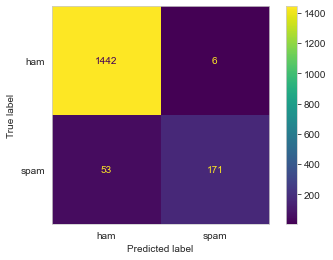

In [37]:
metrics.plot_confusion_matrix(search, X=msg_test, y_true=label_test)
plt.grid(False)
plt.show()